# 第3章 scikit-learn を利用した分類問題

$$
\newcommand{\va}{\mathbf{a}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vmu}{\boldsymbol{\mu}}
$$

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.model_selection import train_test_split

# フィッシャーのあやめデータ
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data[:, [2,3]], iris.target, test_size=0.25, random_state=0)

print('train:', X_train.shape)
print('test:', X_test.shape)

train: (112, 2)
test: (38, 2)


データの標準化

$$
\vx = \frac{\vx - \vmu}{\sigma}, \text{where } \sigma = \frac{(\vx - \vmu)^\top (\vx - \vmu)}{N}
$$

In [3]:
from sklearn.preprocessing import StandardScaler

print('before:')
print(X_train[:,0].std())
print(X_test[:,1].std())

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('after:')
print(X_train_std[:,0].std())
print(X_train_std[:,1].std())

before:
1.7926401405383592
0.6984599203875708
after:
1.0
1.0


パーセプトロンで学習

In [4]:
from sklearn.linear_model import Perceptron

clf = Perceptron(max_iter=4000, eta0=0.1, random_state=0, shuffle=True)
clf.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=4000, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [5]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_std)
print(y_pred)
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))

[2 1 0 2 0 2 0 1 1 1 1 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]
accuracy: 0.95


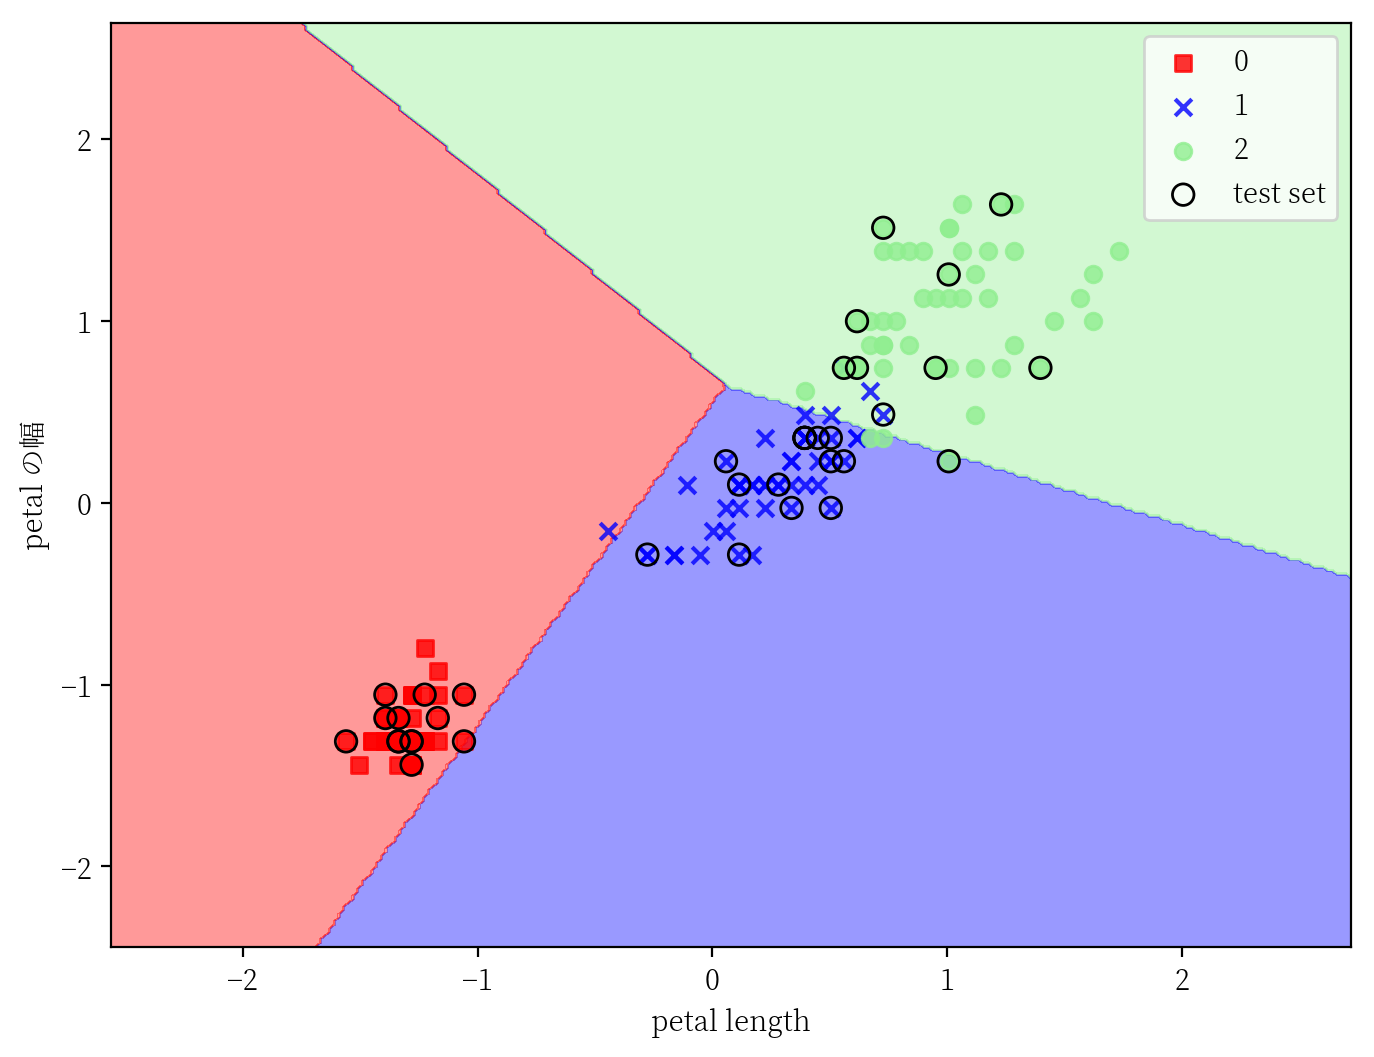

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    """分類器による分類をプロットする
    """
    
    markers = 's x o ^ v'.split()
    colors = 'red blue lightgreen gray cyan'.split()
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1,
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1,
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1], c='', edgecolors='k', s=60,
                    alpha=1, linewidth=1, marker='o', label='test set')
        
X_combined_std = np.r_[X_train_std, X_test_std]
y_combined = np.r_[y_train, y_test]
test_idx = range(X_train.shape[0], X_combined_std.shape[0])

plot_decision_regions(X_combined_std, y_combined, clf, test_idx=test_idx)
plt.xlabel('petal length')
plt.ylabel('petal の幅')
plt.legend()
plt.show()

# 3.3 ロジスティック回帰
---

$$
\sigma(z) = \frac{1}{\exp(-z) + 1}
$$

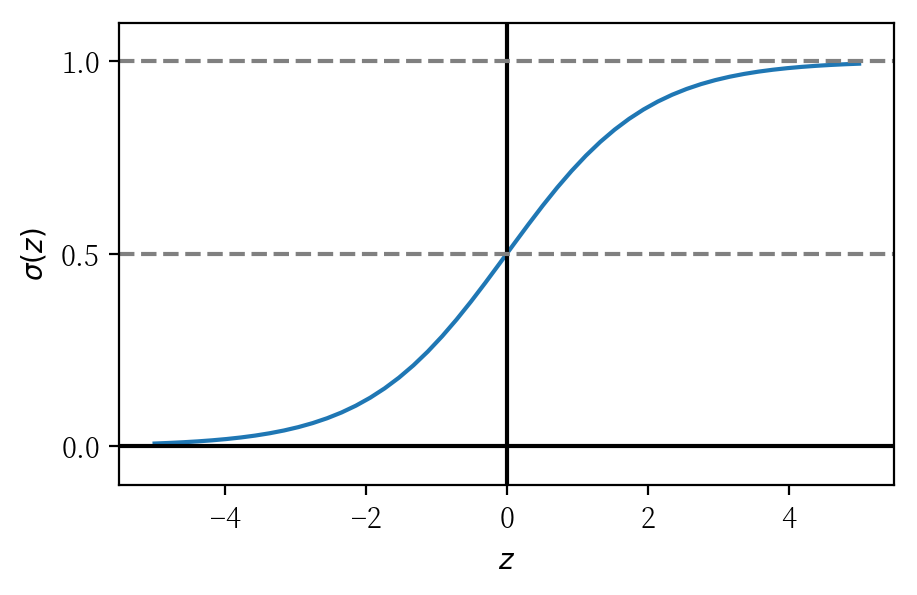

In [7]:
def sigmoid(z):
    return 1.0 / (np.exp(-z) + 1.0)

plt.figure(figsize=(5, 3))
xx = np.linspace(-5, 5)
plt.plot(xx, sigmoid(xx), label='sigmoid')
plt.axvline(0, color='k')
plt.axhline(0, color='k')
plt.axhline(.5, linestyle='--', color='gray')
plt.axhline(1, linestyle='--', color='gray')
plt.xlabel('$z$')
plt.ylabel('$\sigma(z)$')
plt.ylim(-0.1, 1.1)
plt.yticks(np.linspace(0, 1, 3))
plt.show()

#### モデル

$$
y(\vx) = \left\{ \begin{array}{ll}
1 && \text{if}\quad \sigma(\vw^\top \phi(\vx)) \ge 0.5 \\
0 && \text{otherwise}
\end{array}\right.
$$

$w_0$ をバイアスパラメータにしたいので，ここでは基底関数を以下のように定める．

$$
\phi(\vx) = (1, x_1, x_2, \dots, x_n)^\top
$$

#### 損失関数

普通の二乗和誤差 (SSM; Sum of Squared Errors)

$$
J(\vw) = \sum_{n = 1}^{N} (y_n - y(\vx_n))^2
$$

今回はクラスに属する確率が出せるので，尤度を最大化することを考える

$$
\begin{align}
L(\vw) &= \prod_{n = 1}^{N} p(y_n \,|\, \vx_n; \vw) \\
&= \prod_{n = 1}^{N}  \left\{ \begin{array}{ll}
\sigma(\vz_n)     && \text{if}\quad y_n = 1\\
1 - \sigma(\vz_n) && \text{otherwise}
\end{array}\right. \\
&= \prod_{n = 1}^{N} \sigma(\vz_n)^{y_n} (1 - \sigma(\vz_n))^{1 - y_n}
\end{align}
$$
ただし，$\vz_n = \vw^\top \phi(\vx_n)$ である．
2--3 行目の変形に関しては，$y_n \in \{0,1\}$ の性質を利用していることに注意されたい．

$L(\vw)$ が求まったので，対数尤度 $l(\vw)$ は
$$
\begin{align}
l(\vw) &= \log L(\vw) \\
&= \sum_{n = 1}^{N} {y_n} \log \sigma(\vz_n) + (1 - y_n) \log (1 - \sigma(\vz_n))
\end{align}
$$
となり，パラメータベクトル $\vw$ による偏微分は以下の通り．

$$
\begin{align}
\frac{\partial l(\vw)}{\partial \vw} &= \sum_{n = 1}^{N} 
\frac{\partial}{\partial \vz_n} \left\{ {y_n} \log \sigma(\vz_n) + (1 - y_n) \log (1 - \sigma(\vz_n)) \right\}
\frac{\partial \vz_n}{\partial \vw} \\
&= \sum_{n = 1}^{N}
\left\{ {y_n} \frac{\sigma(\vz_n)(1 - \sigma(\vz_n))}{\sigma(\vz_n)} - (1 - y_n) \frac{\sigma(\vz_n)(1 - \sigma(\vz_n))}{1 - \sigma(\vz_n)} \right\}
\phi(\vx_n) \\
&= \sum_{n = 1}^{N} 
\left\{ {y_n} (1 - \sigma(\vz_n)) - (1 - y_n) \sigma(\vz_n) \right\}
\phi(\vx_n) \\
&= \sum_{n = 1}^{N} 
\left\{ y_n - \sigma(\vz_n) \right\}
\phi(\vx_n) \\
&= \Phi^\top \va
\end{align}
$$

ここで，$\Phi$ は $\Phi_{n,:} = \phi(\vx_n)^\top$ を満たす$N\times M$の計画行列であり，$\va = (a_1, \dots, a_N)^\top$ は，$a_n = y_n - \sigma(\vz_n)$ を満たす $N$ 次元ベクトルである．
$$
\Phi = \left( \begin{array}{c}
\phi(\vx_1)^\top \\
\vdots \\
\phi(\vx_N)^\top
\end{array} \right),\quad
\va = \left( \begin{array}{c}
y_1 - \sigma(\vz_1) \\
\vdots \\
y_N - \sigma(\vz_N)
\end{array} \right)
$$

したがって，ロス関数 $J(\vw) = - l(\vw)$ を減少させるような $\vw$ の更新は次のようになる．

$$
\begin{align}
\vw &= \vw - \eta \nabla J(\vw) \\
&= \vw + \eta \Phi^\top \va
\end{align}
$$

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000, random_state=0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

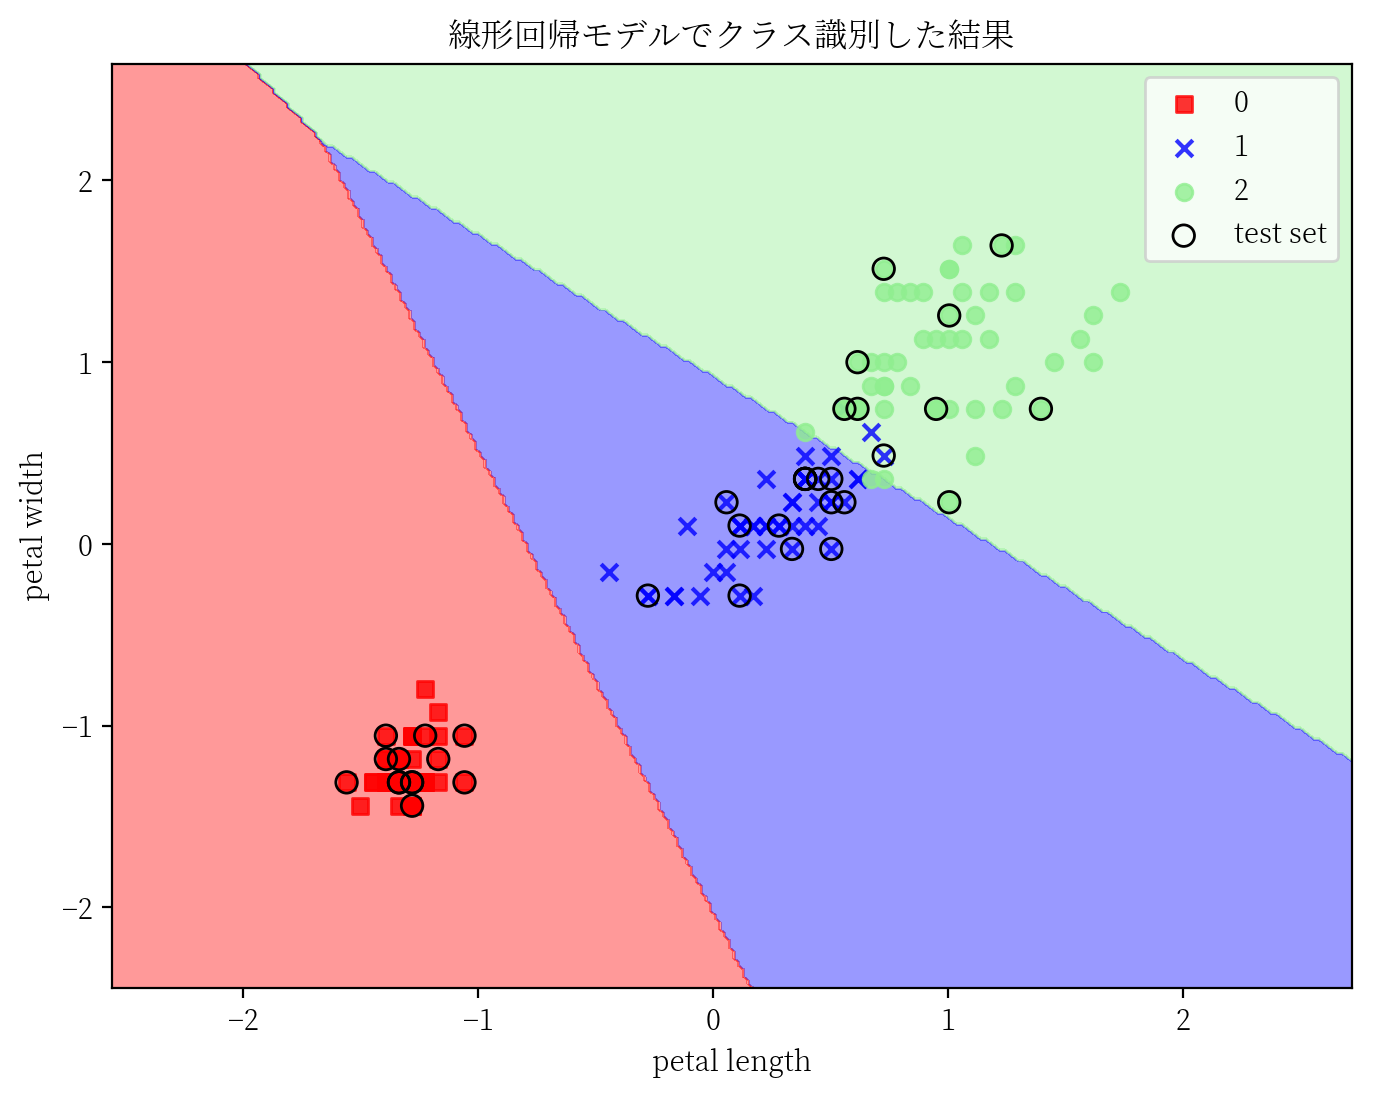

In [9]:
plot_decision_regions(X_combined_std, y_combined, lr, test_idx=test_idx)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.title('線形回帰モデルでクラス識別した結果')
plt.legend()
plt.show()

#### 正則化

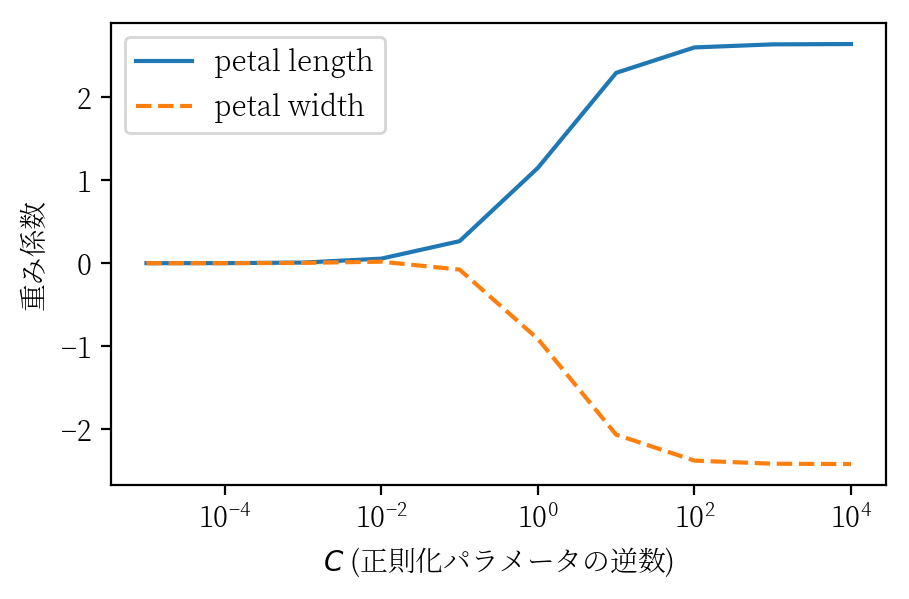

In [10]:
weights, params = [], []

for c in np.arange(-5, 5):
    C = 10.0**c
    lr = LogisticRegression(C=C)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(C)
    
weights = np.array(weights)

plt.figure(figsize=(5,3))
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('重み係数')
plt.xlabel('$C$ (正則化パラメータの逆数)')
plt.legend()
plt.xscale('log')
plt.show()

---

# 3.4. SVM

#### 正規形の識別関数

ロジスティック回帰と同様に，パラメータベクトルに対して線形なモデルを考える．

$$
y_n = y(\vx_n) = \vw^\top \phi(\vx_n) + w_0
$$

サポートベクトルマシン (support vector machine; SVM) は，入力空間において $y(\vx) = 0$ を境界面とするような識別を行う．

仮に，訓練データ $\{(\vx_n, t_n)\}_{n = 1}^N, \, t_n \in \{-1, +1\}$ が線形識別可能であれば，$t_n = 1$ に属する $\vx_{n}$ のうち，最も $y(\vx) = 0$ と距離が短いもの $\vx_s$ を１つ以上選ぶことが可能．

このような $\vx_s$ に対して，$|y(\vx_s)| = 1$ となるように $\vw, w_0$ を調整（それぞれ同じだけ定数倍）する．
この正規化を $t_n = -1$ に対しても同様に行うことで，以下が保証される．

$$
y_n = \left\{ \begin{array}{ll}
\vw^\top \phi(\vx_n) + w_0 \ge 1 & \text{if}\quad t_n = 1 \\
\vw^\top \phi(\vx_n) + w_0 \le -1 & \text{otherwise}
\end{array} \right.
$$

$$
t_n y_n = t_n (\vw^\top \phi(\vx_n) + w_0) \ge 1
$$

このような条件を保証するような $\vw, w_0$ を持つ $y(\vx; \vw, w_0)$ を，**正規形**の識別関数と呼び，SVM では正規形の識別関数を用いることで最適化を簡単にしている．

#### 最適化

具体的には，$\forall n,\, t_n (\vw^\top \phi(\vx_n) + w_0) \ge 1$ を満たしながらマージンを最大化することが目的である．
マージンは，両サイドから 1 つずつ選んだ 2 つのサポートベクトル $\vx_{+s}, \vx_{-s}$ 間の距離で与えられる．

$$
\frac{|\vw^\top \phi(\vx_{+s}) + w_0|}{||\vw||} + 
\frac{|\vw^\top \phi(\vx_{-s}) + w_0|}{||\vw||} = \frac{2}{||\vw||}
$$

したがってラグランジュの未定乗数法によって次の問題を解けば良い．

$$
\begin{array}{rl}
\text{minimize} & \frac{1}{2}||\vw||^2 \\
\text{s.t.} & t_n (\vw^\top \phi(\vx_n) + w_0) - 1 \ge 0 \quad\text{for all $n = 1, \dots, N$}
\end{array}
$$

#### スラック変数

上記の最適化は，線形識別可能なことを前提として行われていた．
そこで，マージンの中に入り込むような $\vx_n$ の存在を許す（ときには境界面を通り越して $t_n y(\vx_n) < 0$ となり，誤識別することもある）ような，より柔軟なモデルを構築する．

*スラック変数*と呼ばれる，「マージンの内側にめり込んでいる距離」を表す $\xi_n \ge 0$ を各データ点に付与する．
* $\xi_n = 0$ のとき，$\vx_n$ は正しく識別されていて，マージンの外側 $t_n y(\vx_n) \ge 1$ に存在する．
* $0 < \xi_n < 1$ のとき，$\vx_n$ は正しく識別されるが，マージンの内側 $0 < t_n y(\vx_n) < 1$ に存在する． 
* $1 < \xi_n$ のとき，$\vx_n$ は誤識別され，境界面の反対側 $t_n y(\vx_n) < 0$ に存在する． 

すなわち，$n=1,\dots,N$ に対して，次の条件が成り立つ．

$$
t_n y(\vx_n) \ge 1 - \xi_n
$$

したがって，解くべき最適化問題は次のように変わる（これも線形不等式制約下でのラグランジュの未定乗数法で解ける）．

$$
\begin{array}{rrl}
\text{minimize} & {\displaystyle \frac{1}{2}||\vw||^2 + C \sum_{n=1}^N \xi_n } & \\
\text{s.t.} & t_n (\vw^\top \phi(\vx_n) + w_0) - 1 + \xi_n \ge 0 & n = 1, \dots, N\\
& \xi_n \ge 0 & n = 1, \dots, N\\
\end{array}
$$

* 「$1 < \xi_n$ のときに $\vx_n$ は誤識別される」ことを考慮すると，$\sum \xi_n$ は誤識別されるデータ数の上界を表している．
* よってパラメータ $C$ を増やすことは，誤識別数を抑制する効果を持つ．
* 実際 $C \to \infty$ でハードマージンと同等

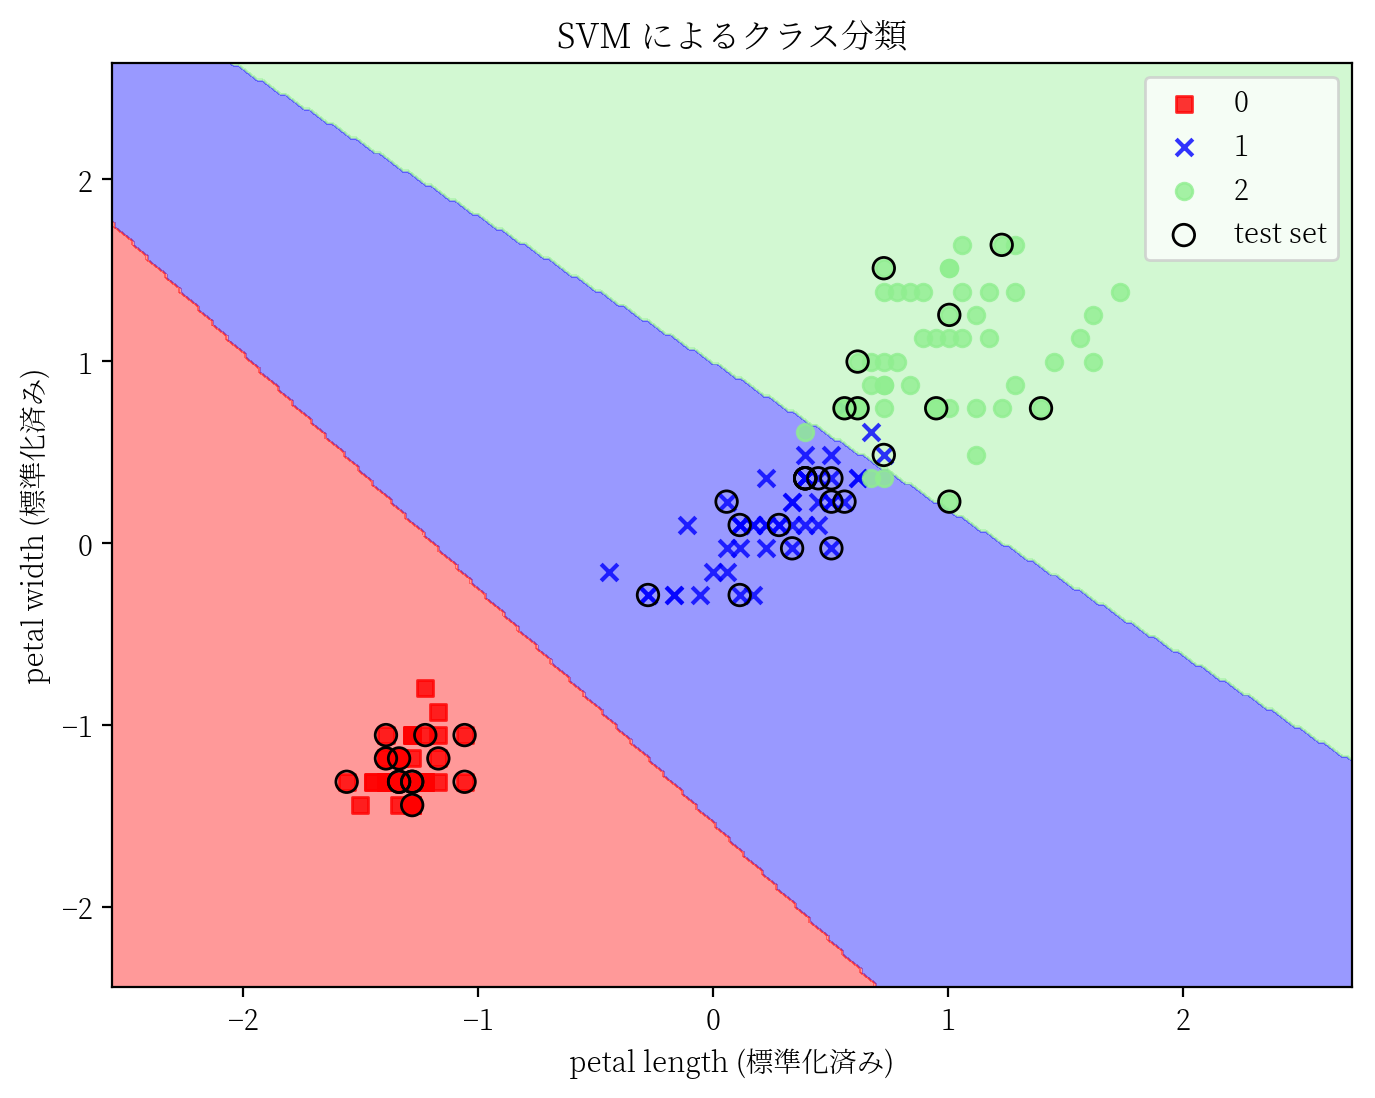

In [11]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, svm, test_idx=test_idx)
plt.xlabel('petal length (標準化済み)')
plt.ylabel('petal width (標準化済み)')
plt.title('SVM によるクラス分類')
plt.legend()
plt.show()

# 3.5. カーネル SVM

$\phi(\vx_n)$ を自前で実装しなくても，カーネル関数 $k(\vx_n, \vx_m) = \phi(\vx_n)^\top \phi(\vx_m)$ を定義するだけで上の最適化問題を解くことができる．

#### 双対問題

ラグランジュ乗数 $a_n, \mu_n \ge 0 \,(n = 1, \dots, N)$ を用いて，スラック変数を導入した最適化問題のラグランジュ関数は以下のように定義される．

$$
\mathcal{L}(\vw, w_0, \va, \boldsymbol\mu) = \frac{1}{2}||\vw||^2 + C \sum_{n=1}^N \xi_n
- \sum_{n=1}^N a_n (t_n y(\vx_n) - 1 + \xi_n)
- \sum_{n=1}^N \mu_n \xi_n
$$

カルーシュ・クーン・タッカー (KKT) 条件 は
$$
\begin{array}{r@{}l}
a_n &\ge 0 \\
t_n y(\vx_n) - 1 + \xi_n &\ge 0 \\
a_n (t_n y(\vx_n) - 1 + \xi_n) &= 0 \\
\mu_n &\ge 0 \\
\xi_n &\ge 0 \\
\mu_n \xi_n &= 0
\end{array}
$$
である．

天下り的ではあるが，停留条件を適切に用いると，以下のような $\va$ に関する二次計画問題として表現できる．

$$
\begin{array}{rl}
\text{minimize} & {\displaystyle \mathcal{L}(\va) = \sum_{n=1}^N a_n - \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N a_n a_m t_n t_m \phi(\vx_n)^\top \phi(\vx_m) } \\
\text{s.t.} & 0 \le a_n \le C, \\
& \sum a_n t_n = 0
\end{array}
$$

#### カーネルトリック

ここで $\mathcal{L}(\va)$ の最後の項に注目すると，$\phi(\vx_n)^\top \phi(\vx_m)$ が出てきているのがわかる．
つまり，$\mathcal{L}(\va)$ を最小化する際には $\phi(\vx_n)$ 単体の値を知る必要はなく，*カーネル関数* $k(\vx_n, \vx_m) = \phi(\vx_n)^\top \phi(\vx_m)$ を計算できれば問題ない．
この性質を活かして，$\phi(\vx_n)$ の空間を定義することなく $\phi(\vx_n)^\top \phi(\vx_m)$ を計算する手法を*カーネルトリック*と呼ぶ．

* カーネル関数は 2 つのデータ間の特徴空間上での距離（近さ）を与えるものである．
* 関数 $k: X^2 \to \mathbb{R}^+: \vx_i, \vx_j \mapsto k(\vx_i, \vx_j)$ がカーネル関数であることの必要十分条件は，$N\times N$のグラム行列 $(K_{ij}) = k(\vx_i, \vx_j)$ が半正定値行列となることである．
* カーネルトリックによって無限次元の特徴空間で内積を取れるようになるが，実際には，$\phi(\vx)$ は特徴空間内で非常に低次元な領域にしか存在しない．

#### ガウスカーネル

もっとも広く使われているカーネルの１つに*動径基底関数 (RBF) カーネル*があり，ガウスカーネルとも呼ばれる．

$$
\begin{align}
k(\vx_n, \vx_m) &= \exp \left\{ - \frac{||\vx_n - \vx_m||^2}{2\sigma^2} \right\} \\
&= \exp \left\{ -\gamma ||\vx_n - \vx_m||^2 \right\}
\end{align}
$$

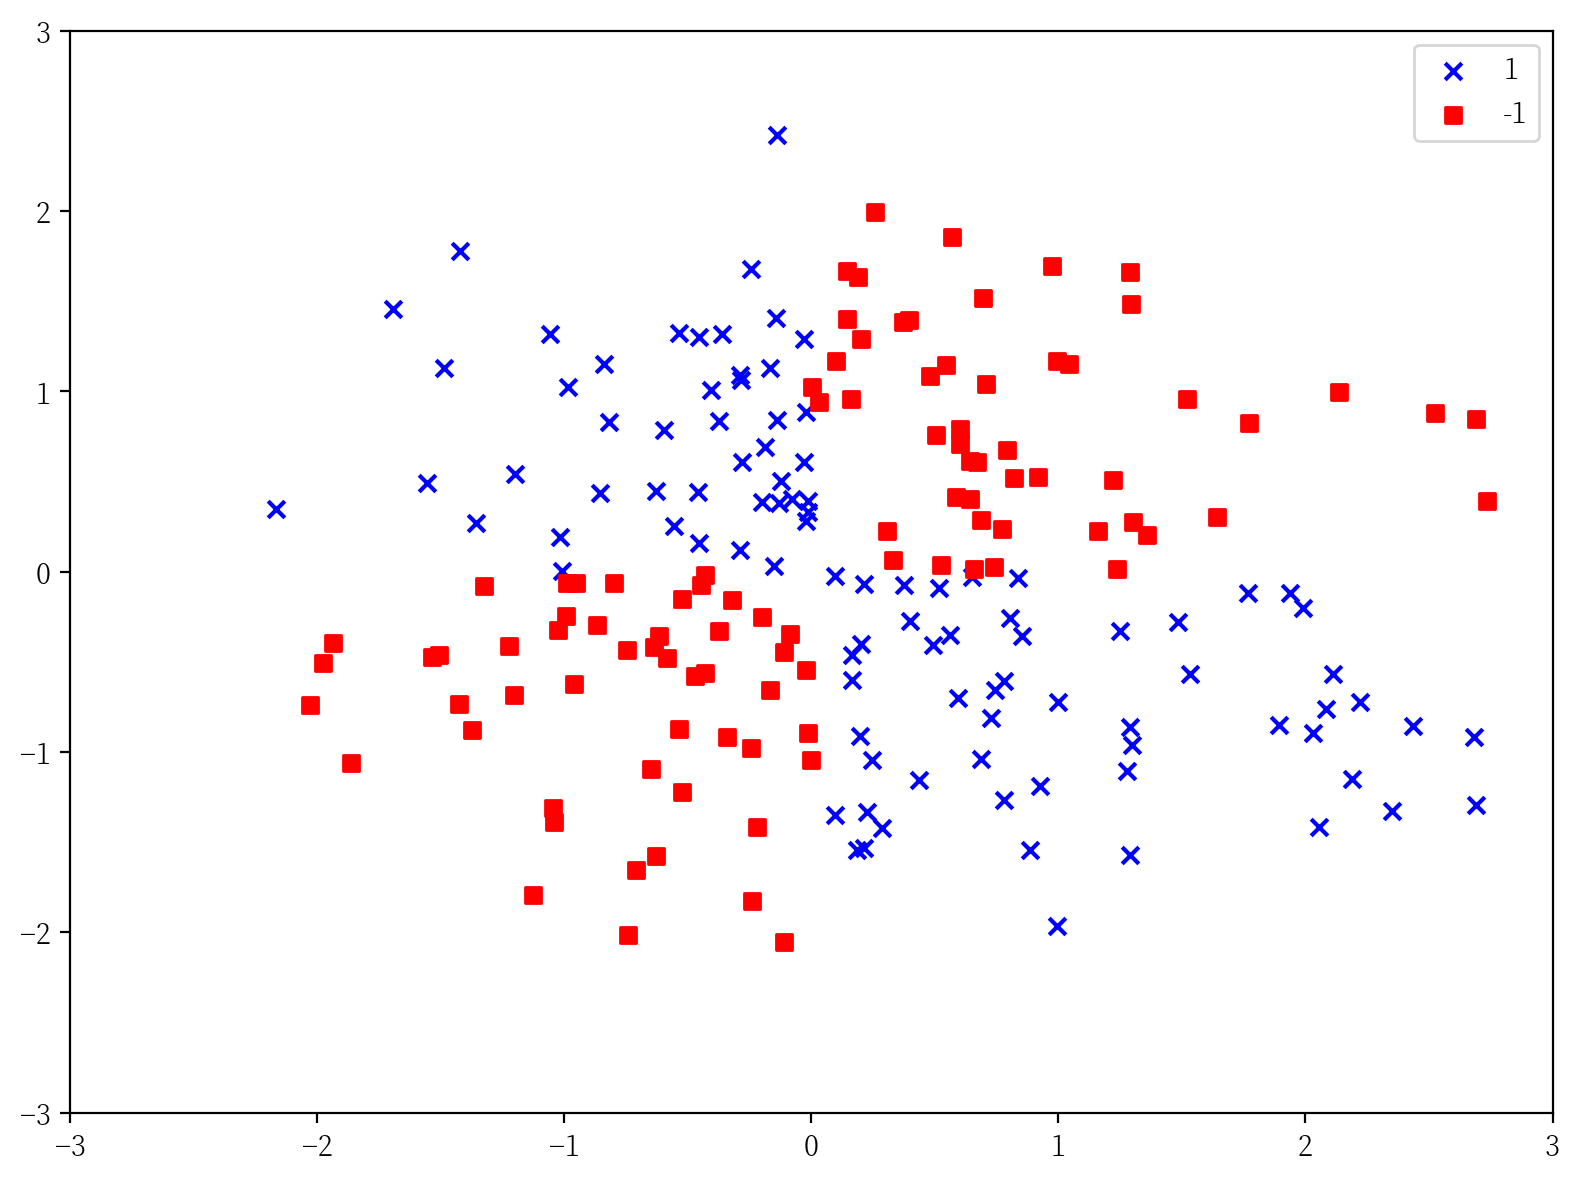

In [12]:
# トイデータ

X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()

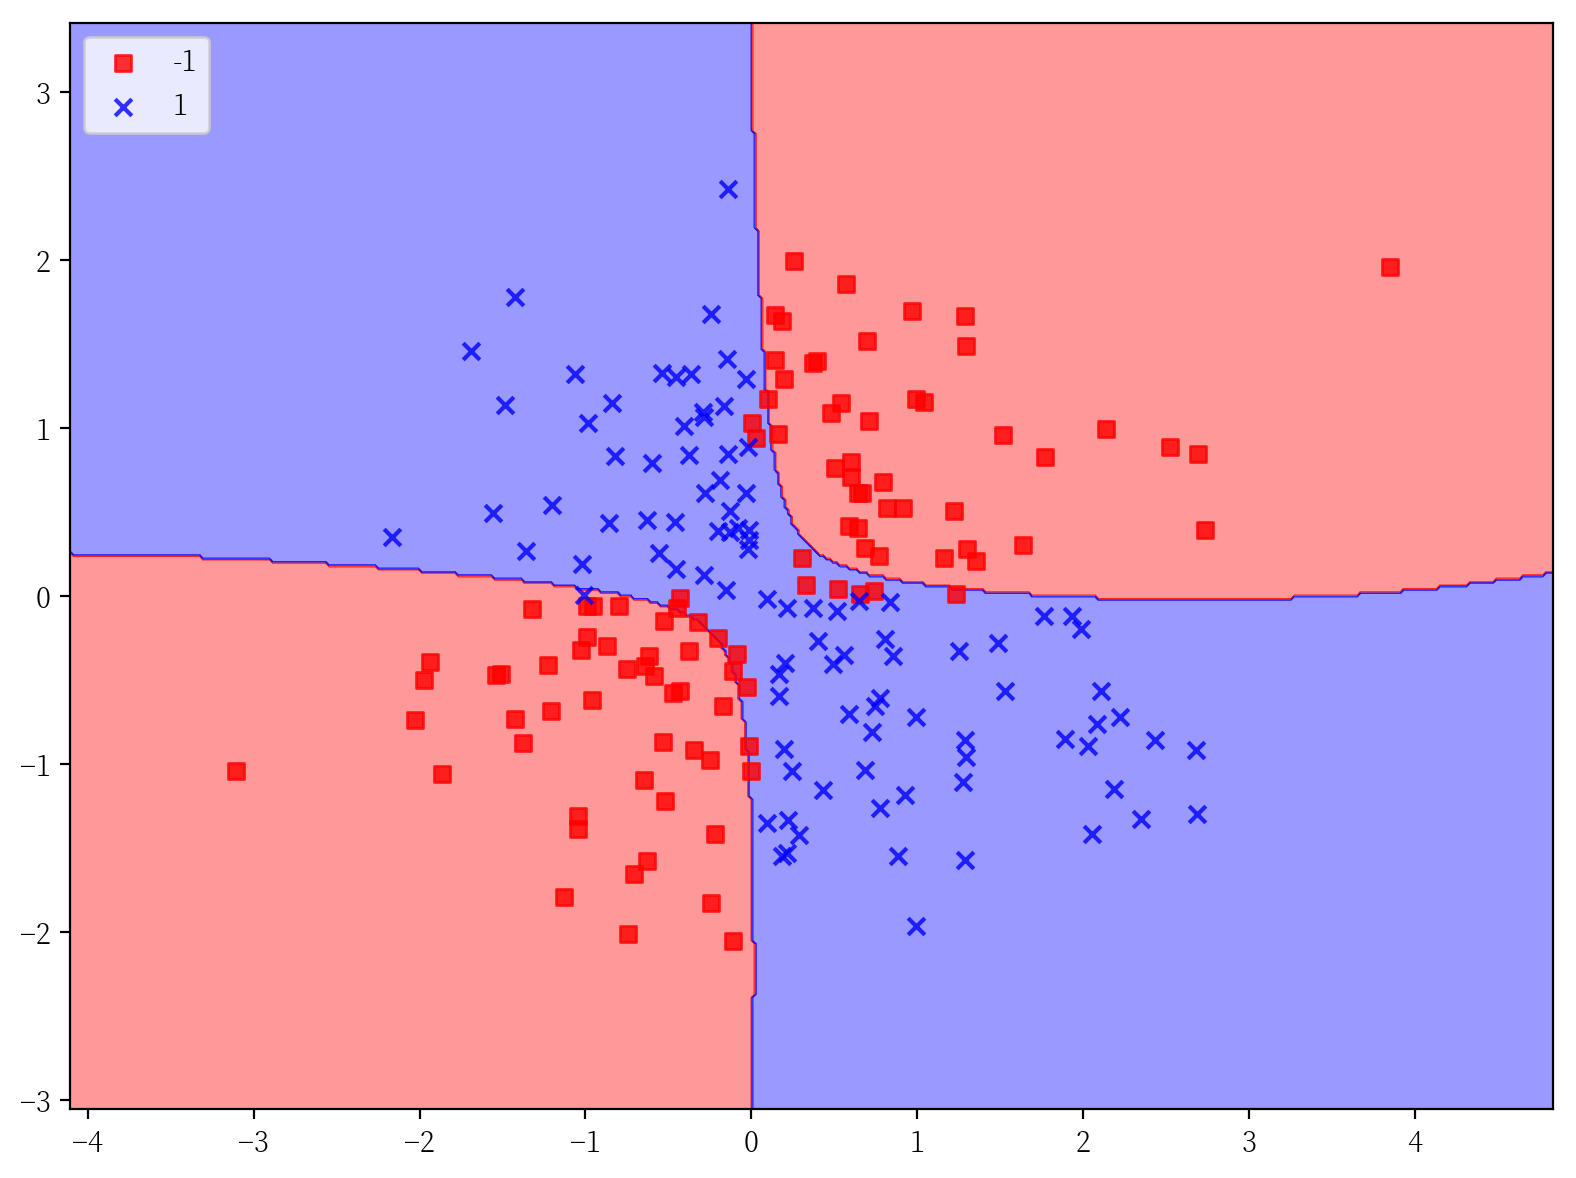

In [13]:
# ガウスカーネル
svm = SVC(kernel='rbf', gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_xor.png', dpi=300)
plt.show()

# 3.6. 決定木

*決定木 (decision tree)* は他クラス分類に用いられる分類器であり，意味解釈性に優れているのが特徴のモデルである．
決定木は木構造で表すことができ，ノードにはある特徴量に対する分割

### 情報利得

一回の分割でどれだけの情報を獲得できたかを表す，*情報利得 (information gain; IG)* を導入する．
$IG$ が大きい分割ほど，ノードの純度を高める優れた分割であり，$IG = 0$ ならその分割では純度はまったく変わらないことを意味する．
* 純度が高いノードとは，データセットが少ないクラス数から構成されているノードを表す．
* 反対に不純度が高いノードは，さまざまなクラスから成る，ごちゃごちゃしているデータセットのノードである．

$$
IG(D_p, f) = I(D_p) - \sum_{j = 1}^m \frac{N_j}{N_p} I(D_j)
$$
ここで，
* $D_p$ は親のデータセット
* $f$ は分割を行う特徴量
* $D_j$ は $j$ 番目の子ノードのデータセット
* $I$ はデータセットの「不純度」を測る関数

#### 不純度の指標

総クラス数が $K$ で，データセット $D = \{(\vx_i, t_i)\}_{i=1}^{|D|}$ が与えられたときの不純度を考える．
便宜上，データセットのデータ数に対する，クラス $k = 1, \dots, K$ に属するデータ点数の割合を $p(k \,|\, D)$ で与える．
$$
p(k \,|\, D) = \frac{| \{ \vx \,|\, (\vx, t) \in D,\, t = k \}|}{|D|}
$$

*エントロピー*
$$
I_H(D) = - \sum_{k = 1}^K p(k \,|\, D) \log_2 p(k \,|\, D)
$$

*ジニ不純度*
$$
I_H(D) = \sum_{k = 1}^K p(k \,|\, D) (1 - p(k \,|\, D))
$$

*分類誤差*
$$
I_E(D) = 1 - \max_{k} p(k \,|\, D))
$$

* すべてのデータセットが，クラス $k_{max} = \text{argmax}\, p(k \,|\, D)$ に属すると仮定した場合の誤分類率を表す．

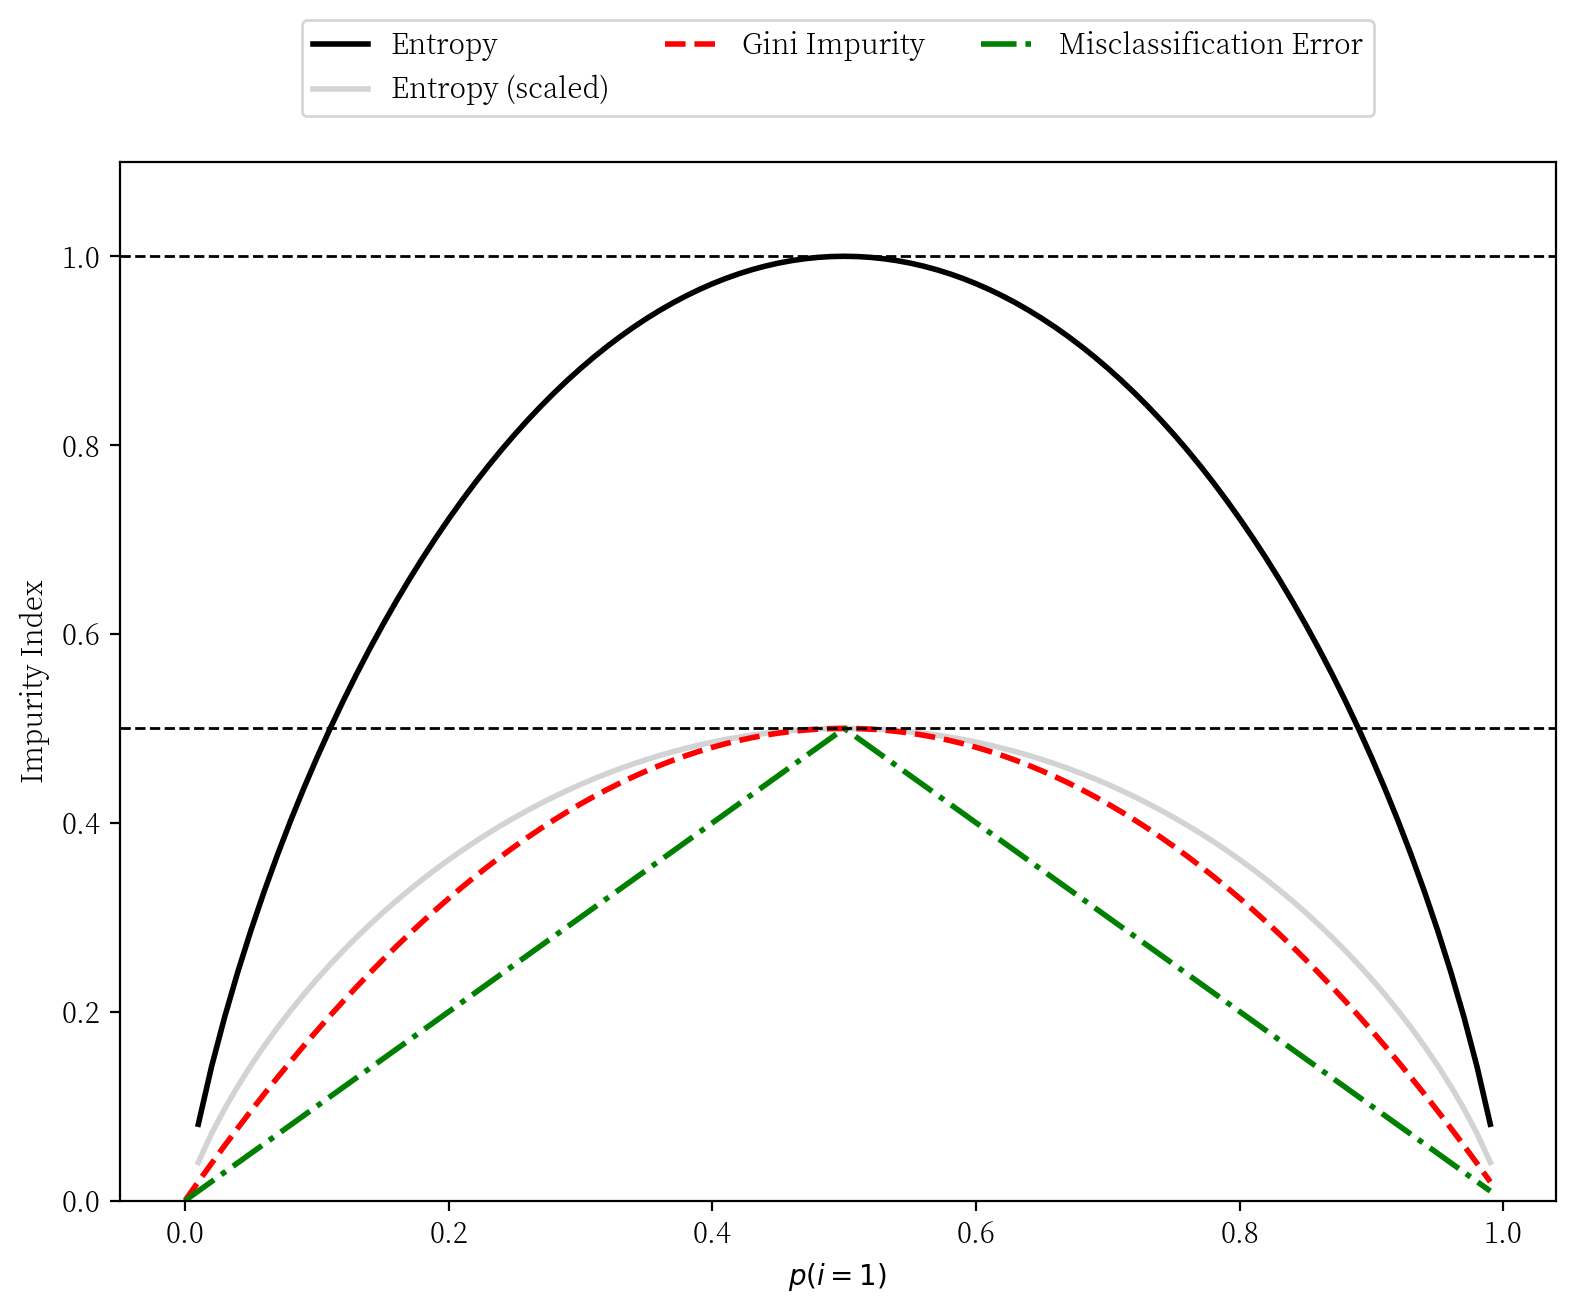

In [14]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('$p(i=1)$')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

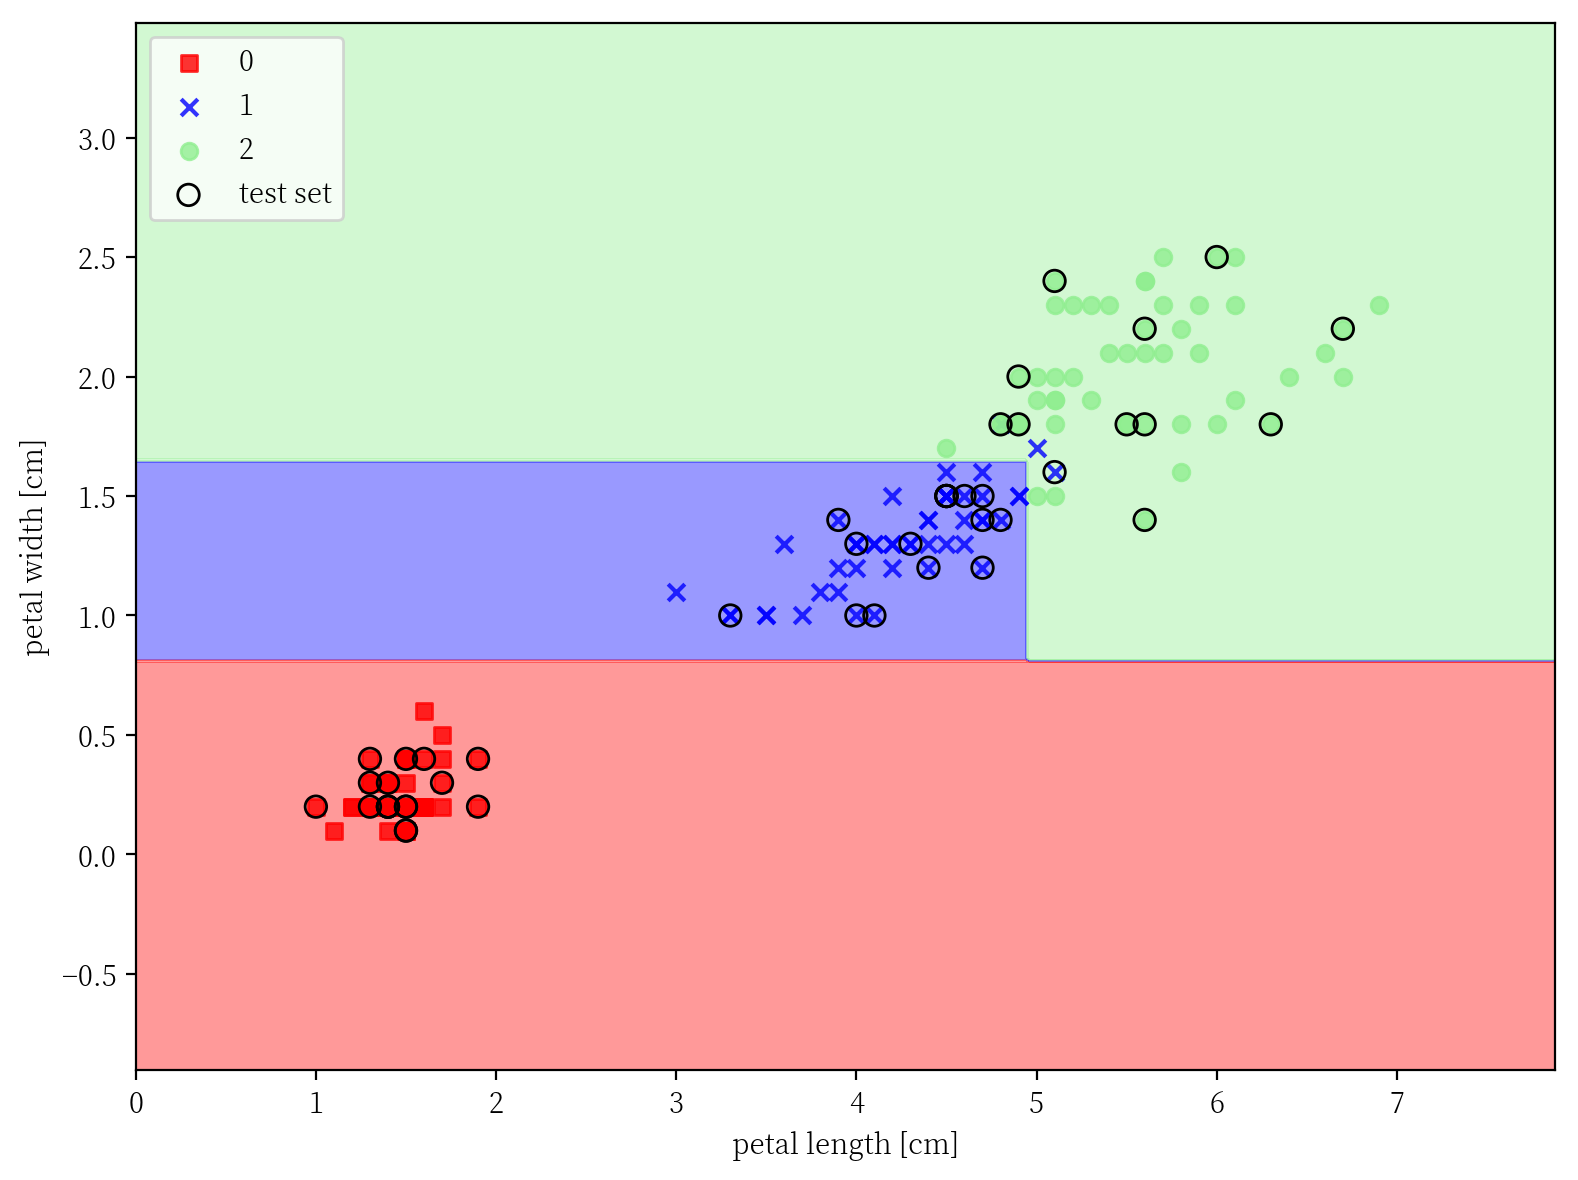

In [15]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)
plt.show()

In [16]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='./out/ch03_tree.dot', feature_names=['petal length', 'petal width'])

# 3.7 k-NN

*k-近傍法* (k-nearest neighbor; KNN) 分類器とは，ノンパラメトリックな識別モデルの１つである．